In [ ]:

import pandas as pd
import scipy.io
import anndata as ad

# 读取基因名称（features）
features = pd.read_csv("/home/xh/data/immune/global_features.tsv", sep="\t", header=None)
# 如果第一行是表头，可以去掉 header=None
# features = pd.read_csv("/home/xh/data/immune/global_features.tsv", sep="\t")

# 读取细胞条形码（barcodes）
barcodes = pd.read_csv("/home/xh/data/immune/global_barcodes.tsv", sep="\t", header=None)
# 如果第一行是表头，可以去掉 header=None
# barcodes = pd.read_csv("/home/xh/data/immune/global_barcodes.tsv", sep="\t")

# 读取元数据（metadata）
metadata = pd.read_csv("/home/xh/data/immune/global_meta.tsv", sep="\t")

# 读取稀疏矩阵（matrix.mtx）
matrix = scipy.io.mmread("/home/xh/data/immune/global_raw_matrix.mtx")

In [ ]:
metadata = pd.read_csv("/home/xh/data/immune/global_meta.tsv", sep="\t", skiprows=[1])
adata = ad.AnnData(
    X=matrix.T,  # 转置矩阵，使行为细胞，列为基因
    obs=metadata.set_index("NAME"),  # 元数据作为观察注释（obs），设置 Barcode 为索引
    var=features.set_index(0)  # 基因信息作为变量注释（var），设置第一列为索引
)
import scipy.sparse as sp

# 确保表达矩阵是 CSR 或 CSC 格式（支持索引操作）
if sp.isspmatrix_coo(adata.X):
    adata.X = adata.X.tocsr() 
    import scanpy as sc

In [ ]:
if 0 in adata.var.index:
    print("adata.var 的索引中包含 0")
else:
    print("adata.var 的索引中不包含 0")
for col in adata.var.columns:
    if (adata.var[col] == 0).any():
        print(f"adata.var 的列 '{col}' 中包含 0")
    else:
        print(f"adata.var 的列 '{col}' 中不包含 0")

In [ ]:
adata.var.index = adata.var.index.astype(str)
adata.obs.columns = adata.obs.columns.astype(str)
adata.var.columns = adata.var.columns.astype(str)
adata_subsampled = sc.pp.subsample(adata, fraction=0.08, copy=True)
adata_subsampled.write("/home/xh/data/immune/subsampled_data.h5ad")
adata.write("/home/xh/data/immune/combined_data.h5ad")

print("h5ad 文件已保存到 /home/xh/data/immune/combined_data.h5ad")

In [ ]:
import numpy as np
np.random.seed(42) # 设置随机种子以确保可重复性 
sample_indices = np.random.choice(adata.shape[0], size=int(0.2 * adata.shape[0]), replace=False) 
train_size = int(0.7 * sample_indices.shape[0]) 
train_adata= adata[sample_indices[:train_size], :] # 按7:3划分训练集和测试集 
test_adata= adata[sample_indices[train_size:], :] 

train_adata.write('/home/xh/data/cancer/train_data.h5ad') 
test_adata.write('/home/xh/data/cancer/test_data.h5ad') 
print('训练集和测试集已成功创建并保存！')

In [ ]:
print(train_adata.var_names)

In [18]:
adata=sc.read("/home/xh/data/Macrophages/train_data.h5ad")
print(list(adata.obs['new_Cell_Type'].unique()))

['AM', 'SAMac', 'Mo_DC_Transitional', 'Kupffer', 'Mo_Classical', 'Mac_CCL2_CCL7', 'Mac_HMOX1', 'Mo_Nonclassical', 'Mac_SLC16A10', 'Resident_Mac_IFN_responsive', 'Mac_RETN', 'Mo_FCN1_CLEC4E', 'Mo_Inflammatory', 'Mac_TIMP1', 'LYZ_KRLG1_high', 'preSAMac_APOE', 'cDC2', 'cDC1', 'Mac_MS4A7', 'Mac_FN1', 'IFN_responsive', 'DC_MHC_high', 'Proliferating', 'Ex_vivo_activated', 'Mature_DCs', 'PPBP_high']


In [19]:
import json

with open("/home/xh/memVP/scgpt/checkpoint/scgpt-human/vocab.json") as f:
    vocab = json.load(f)
vocab_keys = set(vocab)  # Use a set for efficient lookup

count = 0
with open("/home/xh/data/cancer/Wu_etal_2021_allcells_genes.tsv") as f:
    for line in f:
        gene = line.strip()
        if gene in vocab_keys:
            count += 1

print(count)

26736


In [7]:
import scanpy as sc
import pandas as pd

# 读取训练集和测试集
adata_train = sc.read('/home/xh/data/cd4/train.h5ad')
adata_test = sc.read('/home/xh/data/cd4/test.h5ad')

# 读取 meta.tsv 文件
meta_df = pd.read_csv('/home/xh/data/cd4/meta.tsv', sep='\t', index_col=0,skiprows=[1])
meta_df.astype(str)

# 提取训练集和测试集的样本名称
train_samples = adata_train.obs_names
test_samples = adata_test.obs_names

# 根据样本名称匹配元数据
train_meta = meta_df.loc[train_samples]
test_meta = meta_df.loc[test_samples]

# 将元数据添加到 AnnData 对象的 obs 中
adata_train.obs = adata_train.obs.join(train_meta,rsuffix='_meta')
adata_test.obs = adata_test.obs.join(test_meta,rsuffix='_meta')

# 保存更新后的训练集和测试集
adata_train.write('/home/xh/data/cd4/train_with_meta.h5ad')
adata_test.write('/home/xh/data/cd4/test_with_meta.h5ad')

print("元数据已添加到训练集和测试集中，并保存为新的文件。")

元数据已添加到训练集和测试集中，并保存为新的文件。


In [1]:
import json

# 加载 JSON 文件
file_path = "/home/xh/memVP/checkpoint/MemVP-cancer-llama2/preds9.json"
with open(file_path, "r") as f:
    data = json.load(f)

# 提取 pred 和 label
preds = [item["pred"] for item in data]
labels = [item["label"] for item in data]

In [2]:


from sklearn.metrics import confusion_matrix
import numpy as np

# 计算混淆矩阵
cm = confusion_matrix(labels, preds)

# 打印混淆矩阵
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1586    0    8    1    1   69    0    0    0    6    0    1    0    0
     0    0    0    0    0    0    0    0]
 [   0    8    0    1    1   13    2    0    0    1    0    0    0    0
     0    0    0    0    0    0    0    0]
 [  19    0 1528    1    0   49    4    1    1    9    2    0    0    0
     0    1    0    0    0    0    0    0]
 [  20    0    1  566    4   32    0    0    2    1    0    0    0    0
     0    2    0    0    0    0    0    0]
 [   2    0    0    0  139  124    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   2    0    0    0   13  309    1    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   0    0    0    0    0   35  931    0    0    1    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   0    0    6    0    0   14    0   70    0   14    0    0    0    0
     0    0    0    0    0    0    0    0]
 [  14    0    2    0    0   12    0    0  103    0    0    0 

In [3]:
# global_cell_types =['Trm_Th1/Th17',
#  'Trm_gut_CD8','Trm_Tgd','Erythrophagocytic macrophages',
#  'T_CD4/CD8','Trm/em_CD8','Cycling T&NK','Memory B cells','Tregs','Naive B cells','Plasma cells','Teffector/EM_CD4','Tem/emra_CD8','DC2',
#  'Tfh','MNP/B doublets','DC1','ILC3','Tnaive/CM_CD4','Tgd_CRTAM+','Intermediate macrophages','Alveolar macrophages','NK_CD16+','Classical monocytes','Mast cells',
#  'Nonclassical monocytes','Tnaive/CM_CD8','MAIT','pDC', 'Cycling','migDC', 'MNP/T doublets','ABCs','NK_CD56bright_CD16-','Intestinal macrophages','T/B doublets','GC_B (I)','GC_B (II)',
#  'Tnaive/CM_CD4_activated','Plasmablasts','Progenitor','Erythroid','Pro-B','Pre-B','Megakaryocytes']
# 
global_cell_types =['Cancer/Epithelial', 'Plasmablasts', 'T-cells', 'Endothelial', 'PVL cells', 'CAFs', 'Cancer', 'B-cells', 'Myoepithelial', 'Monocytes/Macrophages', 'T-cells Cycling', 'Doublets', 'Monocytes/Macrophages Cycling', 'Mouse 3T3 spike-in', 'Endothelial 1', 'Unassigned', 'Cancer/Epithelial Cycling', 'Endothelial 2', 'NK cells', 'MAST cells', 'pDCs', 'cDCs']

#immue
global_label_mapping = {celltype: i for i, celltype in enumerate(global_cell_types)}

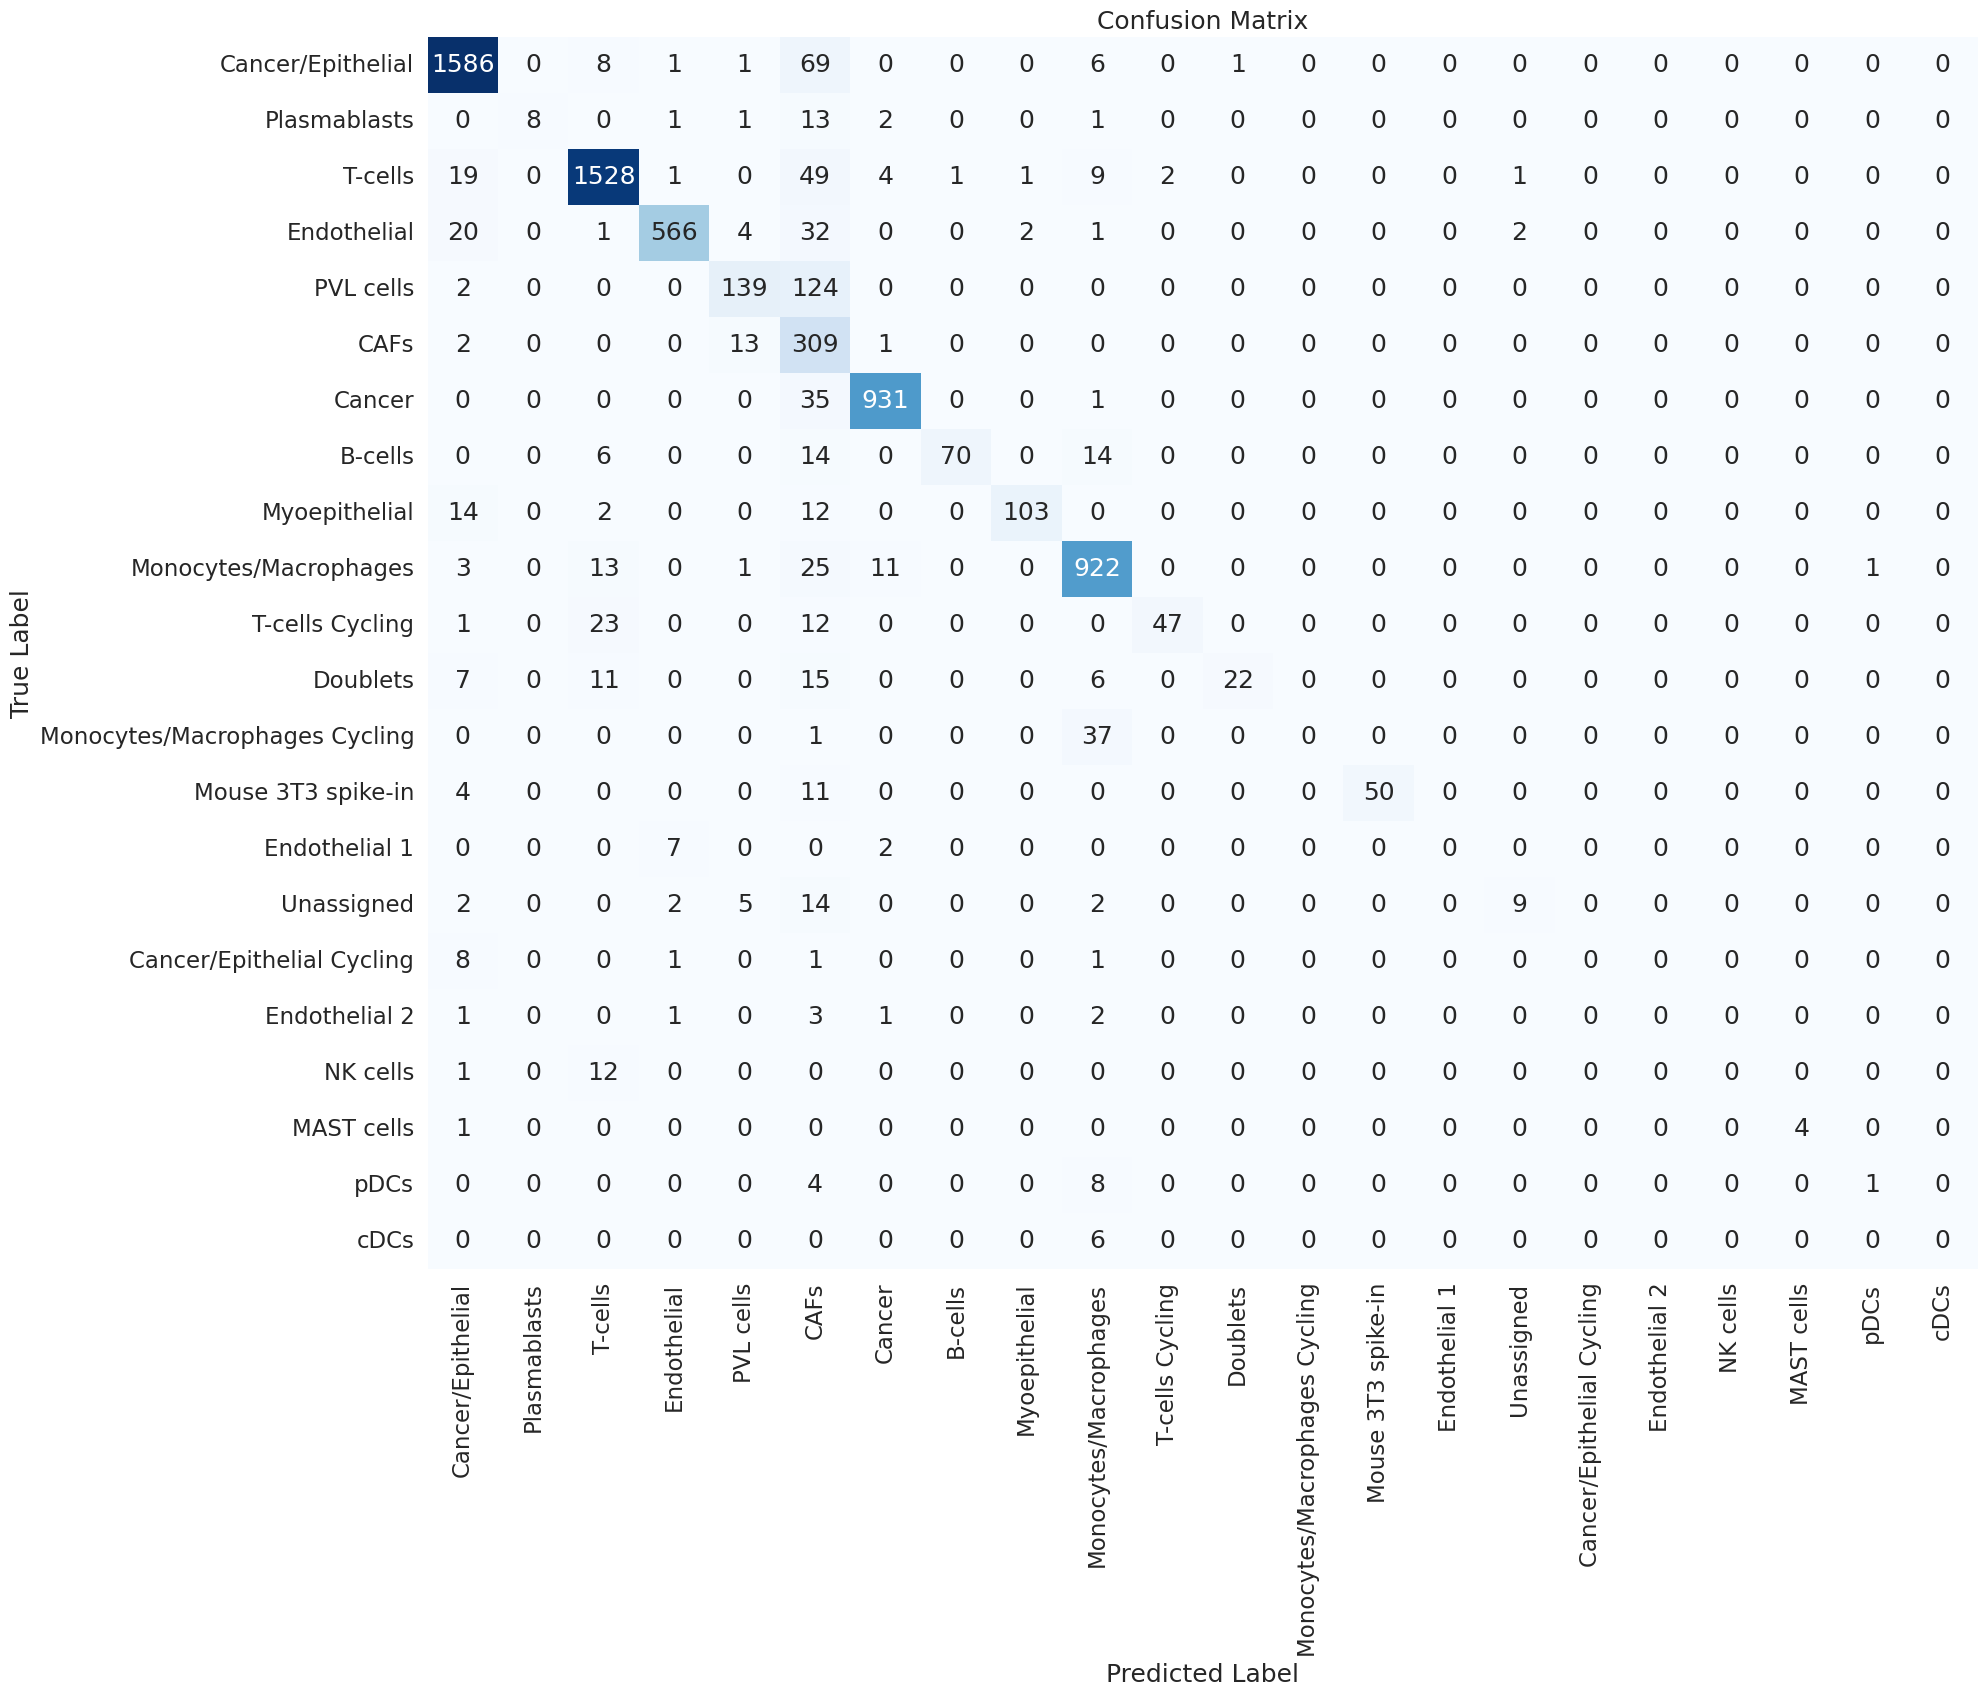

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置绘图风格
plt.figure(figsize=(20, 16))  # 增大图像尺寸
sns.set(font_scale=1.5)  # 增大字体大小

# 绘制热图
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=global_cell_types,
    yticklabels=global_cell_types,
)

# 添加标题和标签
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 保存图像
output_image_path = "/home/xh/memVP/checkpoint/MemVP-cancer-llama2/confusion_matrix.pdf"
plt.savefig(output_image_path, format="pdf", bbox_inches="tight")

# 显示图像
plt.show()

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE

# 1. 加载数据
with open("/home/xh/memVP/checkpoint/MemVP-covid-6144/attention_output.json", "r") as f:
    attention_output = json.load(f)

with open("/home/xh/memVP/checkpoint/MemVP-covid-6144/preds9.json", "r") as f:
    preds = json.load(f)

# 提取特征和预测类别
features = np.array(attention_output)  # 形状为 (num_samples, feature_dim)
print(features.shape)
labels = np.array([item["label"] for item in preds])  # 形状为 (num_samples,)
imputer = SimpleImputer(strategy='mean')
features = imputer.fit_transform(features)
# 2. 降维（选择 PCA 或 t-SNE）
# 使用 PCA 降维
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

# 或者使用 t-SNE 降维
# tsne = TSNE(n_components=2, random_state=42)
# features_2d = tsne.fit_transform(features)

# 3. 可视化
palette = sns.color_palette("husl", n_colors=len(np.unique(labels)))

plt.figure(figsize=(10, 8))
for i, label in enumerate(np.unique(labels)):
    plt.scatter(
        features_2d[labels == label, 0],
        features_2d[labels == label, 1],
        color=palette[i],
        label=f"Class {label}",
        alpha=0.6,
    )

plt.legend(title="Predicted Class", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("celltype")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

# 保存图像
output_image_path = "/home/xh/memVP/checkpoint/MemVP-covid-6144/attention_visualization.png"
plt.savefig(output_image_path, dpi=300, bbox_inches="tight")

# 显示图像
plt.show()

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path
import json
import numpy as np

# 1. 加载测试数据
adata_test = sc.read("/HDDDATA/XieeeHuiii/Data/data/Macrophages/test_data.h5ad")
sc.pp.neighbors(adata_test)  # 计算邻居图
sc.tl.umap(adata_test)   
# 2. 加载预测结果
with open("/home/xh/memVP/checkpoint/checkpoint/MemVP-Macrophages-llama2/preds9.json", "r") as f:
    preds = json.load(f)
with open("/home/xh/memVP/save/dev_Macrophages-Mar16-22-35/predictions_mapped.json", "r") as f:
    predictions_mapped = json.load(f)
# 提取预测标签和真实标签
predictions = np.array([item["pred"] for item in preds])  # 预测标签
labels = np.array([item["label"] for item in preds])     # 真实标签

# 3. 定义细胞类型映射
global_cell_types =['macrophage', 'classical monocyte', 'monocyte', 'conventional dendritic cell', 'Kupffer cell', 'non-classical monocyte', 'alveolar macrophage', 'mature conventional dendritic cell', 'apoptosis fated cell', 'mitotic cell cycle']


# 创建标签到细胞类型的映射
id2type = {i: celltype for i, celltype in enumerate(global_cell_types)}

# 将预测标签和真实标签映射到细胞类型名称
adata_test.obs["predictions"] = [id2type[p] for p in predictions]  # 预测细胞类型
adata_test.obs["celltype"] = [id2type[l] for l in labels]          # 真实细胞类型
adata_test.obs["predictions_scgpt"] = predictions_mapped
# 4. 绘制 UMAP 图
# 设置调色板
# 获取默认颜色循环
palette_ = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# 如果颜色不够，可以重复扩展
palette_ = palette_ * (len(global_cell_types) // len(palette_) + 1)
palette_ = palette_[:len(global_cell_types)]

# 创建颜色映射
palette_ = {c: palette_[i] for i, c in enumerate(global_cell_types)}

# 设置保存目录
save_dir = Path("./save")
save_dir.mkdir(parents=True, exist_ok=True)

# 创建画布和子图
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))  # 1 行 3 列，图像大小为 20x6

# 在第一个子图中绘制真实细胞类型的 UMAP 图
sc.pl.umap(adata_test, color="celltype", ax=ax1, palette=palette_, show=False, title="True Cell Types", legend_loc=None)  # 不显示图例

# 在第二个子图中绘制预测细胞类型的 UMAP 图
sc.pl.umap(adata_test, color="predictions", ax=ax3, palette=palette_, show=False, title="Predicted Cell Types", legend_loc=None)  # 不显示图例
sc.pl.umap(adata_test, color="predictions_scgpt", ax=ax2, palette=palette_, show=False, title="Predicted Cell Types of scgpt", legend_loc=None)  # 不显示图例
# 调整子图之间的间距
plt.subplots_adjust(wspace=0.2)  # 增加水平间距

# 创建共享的图例
from matplotlib.patches import Patch

# 手动创建图例句柄和标签
handles = [Patch(color=palette_[celltype], label=celltype) for celltype in global_cell_types]
labels = global_cell_types

# 将图例放在图像下方
fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.1, 0.5), ncol=1, fontsize=10)


# 保存图像
plt.savefig(save_dir / "Macrophages-easy_results.png", dpi=300, bbox_inches="tight")  # bbox_inches="tight" 确保图例不被裁剪
plt.show()  # 显示图像

/home/xh/.conda/envs/memvp/lib/python3.10/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 35605 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


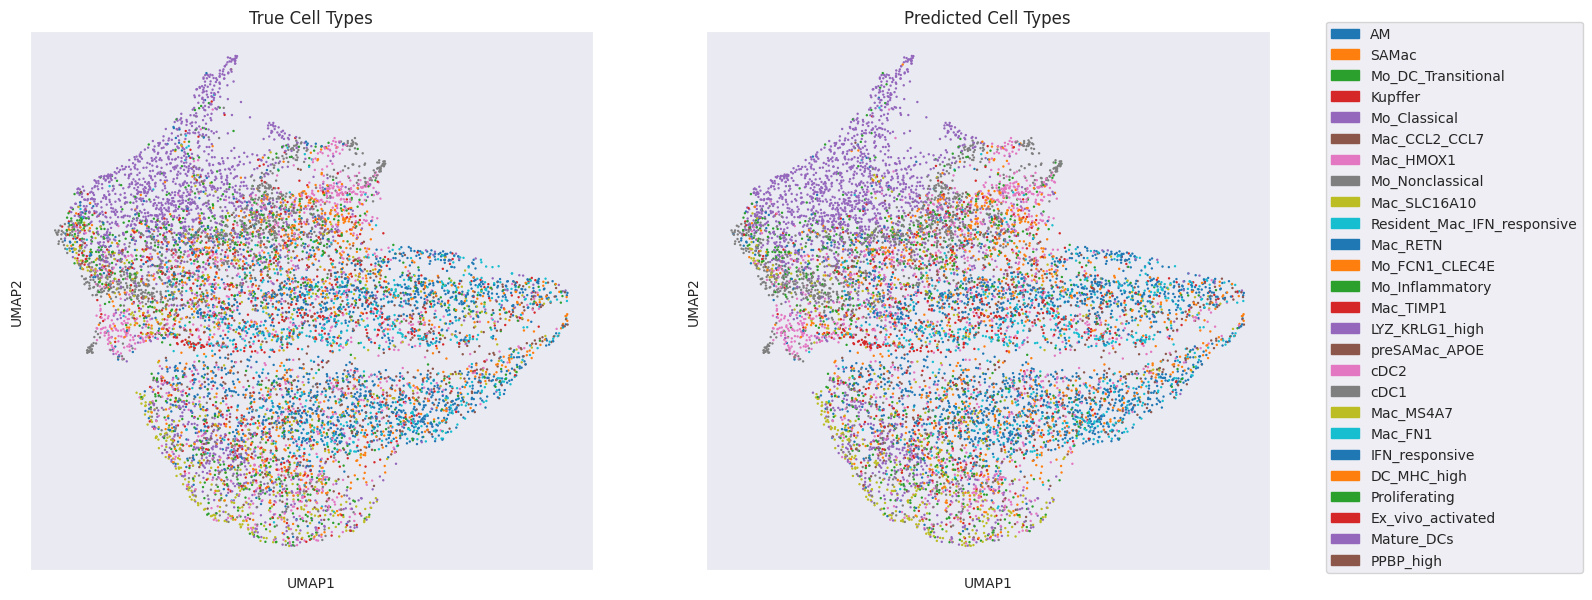

In [35]:
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path
import json
import numpy as np

# 1. 加载测试数据
adata_test = sc.read("/HDDDATA/XieeeHuiii/Data/data/Macrophages/test_data.h5ad")
sc.pp.neighbors(adata_test)  # 计算邻居图
sc.tl.umap(adata_test)   
# 2. 加载预测结果
with open("/home/xh/memVP/checkpoint/checkpoint/MemVP-Macrophages-llama2-hard/preds9.json", "r") as f:
    preds = json.load(f)
with open("/home/xh/memVP/save/dev_Macrophages-Mar16-21-32/predictions_mapped.json", "r") as f:
    predictions_mapped = json.load(f)
# 提取预测标签和真实标签
predictions = np.array([item["pred"] for item in preds])  # 预测标签
labels = np.array([item["label"] for item in preds])     # 真实标签

# 3. 定义细胞类型映射
global_cell_types =['AM', 'SAMac', 'Mo_DC_Transitional', 'Kupffer', 'Mo_Classical', 'Mac_CCL2_CCL7',
                    'Mac_HMOX1', 'Mo_Nonclassical', 'Mac_SLC16A10', 'Resident_Mac_IFN_responsive', 'Mac_RETN',
                    'Mo_FCN1_CLEC4E', 'Mo_Inflammatory', 'Mac_TIMP1', 'LYZ_KRLG1_high', 'preSAMac_APOE', 'cDC2',
                    'cDC1', 'Mac_MS4A7', 'Mac_FN1', 'IFN_responsive',
                    'DC_MHC_high', 'Proliferating', 'Ex_vivo_activated', 'Mature_DCs', 'PPBP_high']


# 创建标签到细胞类型的映射
id2type = {i: celltype for i, celltype in enumerate(global_cell_types)}

# 将预测标签和真实标签映射到细胞类型名称
adata_test.obs["predictions"] = [id2type[p] for p in predictions]  # 预测细胞类型
adata_test.obs["celltype"] = [id2type[l] for l in labels]          # 真实细胞类型
adata_test.obs["predictions_scgpt"] = predictions_mapped
# 4. 绘制 UMAP 图
# 设置调色板
# 获取默认颜色循环
palette_ = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# 如果颜色不够，可以重复扩展
palette_ = palette_ * (len(global_cell_types) // len(palette_) + 1)
palette_ = palette_[:len(global_cell_types)]

# 创建颜色映射
palette_ = {c: palette_[i] for i, c in enumerate(global_cell_types)}

# 设置保存目录
save_dir = Path("./save")
save_dir.mkdir(parents=True, exist_ok=True)

# 创建画布和子图
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))  # 1 行 3 列，图像大小为 20x6

# 在第一个子图中绘制真实细胞类型的 UMAP 图
sc.pl.umap(adata_test, color="celltype", ax=ax1, palette=palette_, show=False, title="True Cell Types", legend_loc=None)  # 不显示图例

# 在第二个子图中绘制预测细胞类型的 UMAP 图
sc.pl.umap(adata_test, color="predictions", ax=ax3, palette=palette_, show=False, title="Predicted Cell Types", legend_loc=None)  # 不显示图例
sc.pl.umap(adata_test, color="predictions_scgpt", ax=ax2, palette=palette_, show=False, title="Predicted Cell Types of scgpt", legend_loc=None)  # 不显示图例
# 调整子图之间的间距
plt.subplots_adjust(wspace=0.2)  # 增加水平间距

# 创建共享的图例
from matplotlib.patches import Patch

# 手动创建图例句柄和标签
handles = [Patch(color=palette_[celltype], label=celltype) for celltype in global_cell_types]
labels = global_cell_types

# 将图例放在图像下方
fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.1, 0.5), ncol=1, fontsize=10)


# 保存图像
plt.savefig(save_dir / "Macrophages-hard_results.png", dpi=300, bbox_inches="tight")  # bbox_inches="tight" 确保图例不被裁剪
plt.show()  # 显示图像

/home/xh/.conda/envs/memvp/lib/python3.10/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 36601 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


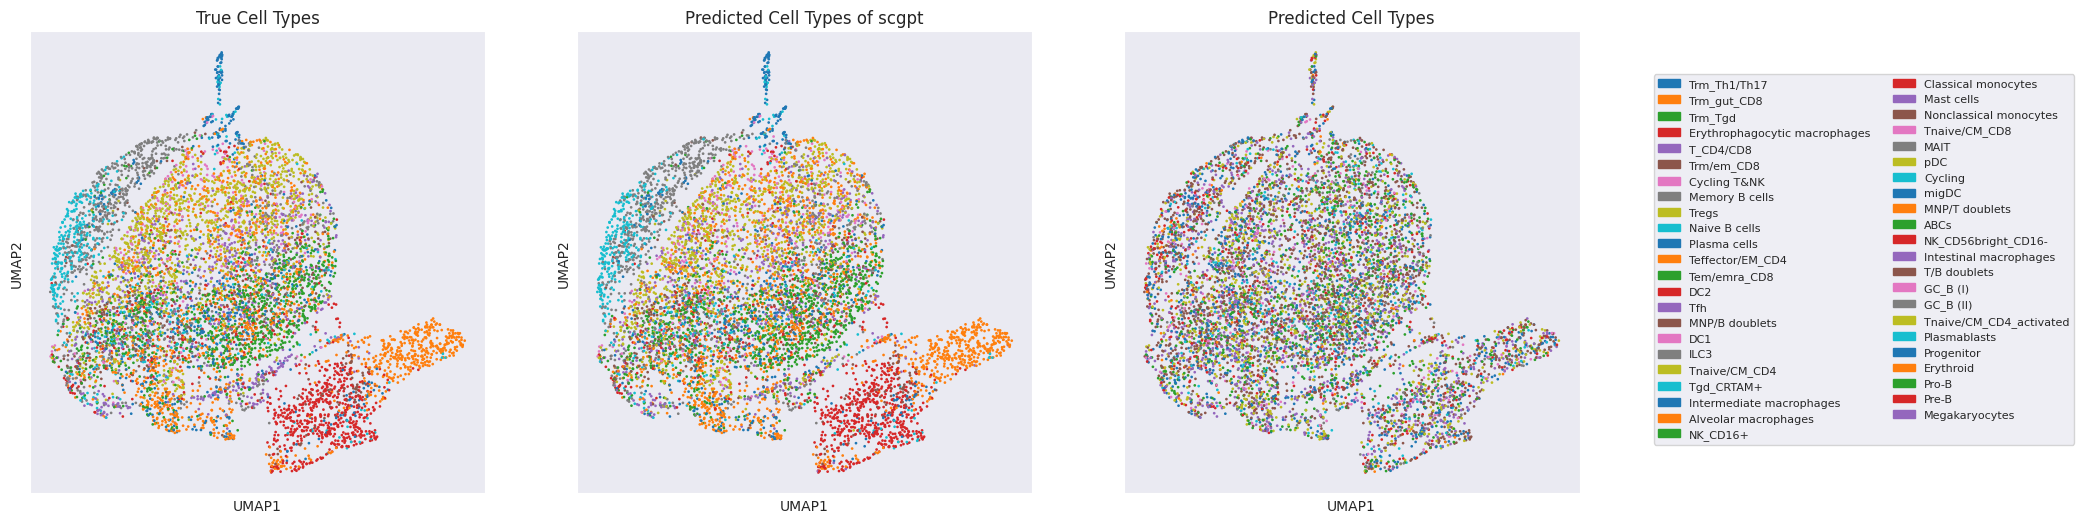

In [4]:
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path
import json
import numpy as np

# 1. 加载测试数据
adata_test = sc.read("/HDDDATA/XieeeHuiii/Data/data/immune/test_data.h5ad")
sc.pp.neighbors(adata_test)  # 计算邻居图
sc.tl.umap(adata_test)   
# 2. 加载预测结果
with open("/home/xh/memVP/checkpoint/checkpoint/MemVP-immune-nofeature/preds9.json", "r") as f:
    preds = json.load(f)
with open("/home/xh/memVP/save/dev_immune-Mar16-16-41/predictions_mapped.json", "r") as f:
    predictions_mapped = json.load(f)
# 提取预测标签和真实标签
predictions = np.array([item["pred"] for item in preds])  # 预测标签
labels = np.array([item["label"] for item in preds])     # 真实标签

# 3. 定义细胞类型映射
global_cell_types =['Trm_Th1/Th17',
 'Trm_gut_CD8','Trm_Tgd','Erythrophagocytic macrophages',
 'T_CD4/CD8','Trm/em_CD8','Cycling T&NK','Memory B cells','Tregs','Naive B cells','Plasma cells','Teffector/EM_CD4','Tem/emra_CD8','DC2',
 'Tfh','MNP/B doublets','DC1','ILC3','Tnaive/CM_CD4','Tgd_CRTAM+','Intermediate macrophages','Alveolar macrophages','NK_CD16+','Classical monocytes','Mast cells',
 'Nonclassical monocytes','Tnaive/CM_CD8','MAIT','pDC', 'Cycling','migDC', 'MNP/T doublets','ABCs','NK_CD56bright_CD16-','Intestinal macrophages','T/B doublets','GC_B (I)','GC_B (II)',
 'Tnaive/CM_CD4_activated','Plasmablasts','Progenitor','Erythroid','Pro-B','Pre-B','Megakaryocytes']


# 创建标签到细胞类型的映射
id2type = {i: celltype for i, celltype in enumerate(global_cell_types)}

# 将预测标签和真实标签映射到细胞类型名称
adata_test.obs["predictions"] = [id2type[p] for p in predictions]  # 预测细胞类型
adata_test.obs["celltype"] = [id2type[l] for l in labels]          # 真实细胞类型
adata_test.obs["predictions_scgpt"] = predictions_mapped 
# 4. 绘制 UMAP 图
# 设置调色板
# 获取默认颜色循环
palette_ = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# 如果颜色不够，可以重复扩展
palette_ = palette_ * (len(global_cell_types) // len(palette_) + 1)
palette_ = palette_[:len(global_cell_types)]

# 创建颜色映射
palette_ = {c: palette_[i] for i, c in enumerate(global_cell_types)}

# 设置保存目录
save_dir = Path("./save")
save_dir.mkdir(parents=True, exist_ok=True)

# 创建画布和子图
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))  # 1 行 3 列，图像大小为 20x6

# 在第一个子图中绘制真实细胞类型的 UMAP 图
sc.pl.umap(adata_test, color="celltype", ax=ax1, palette=palette_, show=False, title="True Cell Types", legend_loc=None)  # 不显示图例

# 在第二个子图中绘制预测细胞类型的 UMAP 图
sc.pl.umap(adata_test, color="predictions", ax=ax3, palette=palette_, show=False, title="Predicted Cell Types", legend_loc=None)  # 不显示图例
sc.pl.umap(adata_test, color="predictions_scgpt", ax=ax2, palette=palette_, show=False, title="Predicted Cell Types of scgpt", legend_loc=None)  # 不显示图例
# 调整子图之间的间距
plt.subplots_adjust(wspace=0.2)  # 增加水平间距

# 创建共享的图例
from matplotlib.patches import Patch

# 手动创建图例句柄和标签
handles = [Patch(color=palette_[celltype], label=celltype) for celltype in global_cell_types]
labels = global_cell_types

# 将图例放在图像下方
fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.15, 0.5), ncol=2, fontsize=8)


# 保存图像
plt.savefig(save_dir / "immune_results.png", dpi=300, bbox_inches="tight")  # bbox_inches="tight" 确保图例不被裁剪
plt.show()  # 显示图像

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path
import json
import numpy as np

# 1. 加载测试数据
adata_test = sc.read("/HDDDATA/XieeeHuiii/Data/data/cancer/test_data.h5ad")
sc.pp.neighbors(adata_test)  # 计算邻居图
sc.tl.umap(adata_test)   
# 2. 加载预测结果
with open("/home/xh/memVP/checkpoint/checkpoint/MemVP-cancer-llama2/preds9.json", "r") as f:
    preds = json.load(f)

# 提取预测标签和真实标签
predictions = np.array([item["pred"] for item in preds])  # 预测标签
labels = np.array([item["label"] for item in preds])     # 真实标签

# 3. 定义细胞类型映射
global_cell_types =['Cancer/Epithelial', 'Plasmablasts', 'T-cells', 'Endothelial', 'PVL cells', 'CAFs', 'Cancer', 'B-cells', 'Myoepithelial', 'Monocytes/Macrophages', 'T-cells Cycling', 'Doublets', 'Monocytes/Macrophages Cycling', 'Mouse 3T3 spike-in', 'Endothelial 1', 'Unassigned', 'Cancer/Epithelial Cycling', 'Endothelial 2', 'NK cells', 'MAST cells', 'pDCs', 'cDCs']


# 创建标签到细胞类型的映射
id2type = {i: celltype for i, celltype in enumerate(global_cell_types)}

# 将预测标签和真实标签映射到细胞类型名称
adata_test.obs["predictions"] = [id2type[p] for p in predictions]  # 预测细胞类型
adata_test.obs["celltype"] = [id2type[l] for l in labels]          # 真实细胞类型
adata_test.obs["predictions_scgpt"] = predictions_mapped  # 第二个模型的预测细胞类型
# 4. 绘制 UMAP 图
# 设置调色板
# 获取默认颜色循环
palette_ = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# 如果颜色不够，可以重复扩展
palette_ = palette_ * (len(global_cell_types) // len(palette_) + 1)
palette_ = palette_[:len(global_cell_types)]

# 创建颜色映射
palette_ = {c: palette_[i] for i, c in enumerate(global_cell_types)}

# 设置保存目录
save_dir = Path("./save")
save_dir.mkdir(parents=True, exist_ok=True)

# 创建画布和子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))  # 增加画布高度

# 在第一个子图中绘制真实细胞类型的 UMAP 图
sc.pl.umap(adata_test, color="celltype", ax=ax1, palette=palette_, show=False, title="True Cell Types", legend_loc=None)  # 不显示图例

# 在第二个子图中绘制预测细胞类型的 UMAP 图
sc.pl.umap(adata_test, color="predictions", ax=ax3, palette=palette_, show=False, title="Predicted Cell Types", legend_loc=None)  # 不显示图例
sc.pl.umap(adata_test, color="predictions_scgpt", ax=ax2, palette=palette_, show=False, title="Predicted Cell Types of scgpt", legend_loc=None)  # 不显示图例
# 调整子图之间的间距
plt.subplots_adjust(wspace=0.2)  # 增加水平间距

# 创建共享的图例
from matplotlib.patches import Patch

# 手动创建图例句柄和标签
handles = [Patch(color=palette_[celltype], label=celltype) for celltype in global_cell_types]
labels = global_cell_types

# 将图例放在图像下方
fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.1, 0.5), ncol=1, fontsize=10)


# 保存图像
plt.savefig(save_dir / "cancer_results.png", dpi=300, bbox_inches="tight")  # bbox_inches="tight" 确保图例不被裁剪
plt.show()  # 显示图像

/home/xh/.conda/envs/memvp/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xh/.conda/envs/memvp/lib/python3.10/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 29927 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
/home/xh/.conda/envs/memvp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'predictions_mapped' is not defined

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path
import json
import numpy as np

# 1. 加载测试数据
adata_test = sc.read("/HDDDATA/XieeeHuiii/Data/data/covid-19/filtered_covid_portal_test_10k.h5ad")

# 2. 加载预测结果
with open("/home/xh/memVP/checkpoint/MemVP-covid-6144/preds9.json", "r") as f:
    preds = json.load(f)

# 提取预测标签和真实标签
predictions = np.array([item["pred"] for item in preds])  # 预测标签
labels = np.array([item["label"] for item in preds])     # 真实标签
with open("/home/xh/memVP/save/dev_covid-Mar16-15-38/predictions_mapped.json", "r") as f:
    predictions_mapped = json.load(f)
# 3. 定义细胞类型映射
global_cell_types = [
    'CD4.Tfh', 'CD16_mono', 'CD8.TE', 'CD83_CD14_mono', 'CD14_mono',
    'NK_16hi', 'CD4.CM', 'B_naive', 'B_immature', 'MAIT', 'CD8.EM', 'NKT', 'CD8.Naive',
    'CD4.Naive', 'gdT', 'B_non-switched_memory', 'B_exhausted', 'DC2', 'HSC_CD38pos', 'CD4.Prolif',
    'C1_CD16_mono', 'CD4.IL22', 'CD4.EM', 'Platelets', 'Plasmablast', 'HSC_CD38neg', 'Plasma_cell_IgA', 'pDC',
    'NK_56hi', 'DC3', 'CD4.Th1', 'B_switched_memory', 'Plasma_cell_IgG', 'B_malignant', 'NK_prolif', 'Mono_prolif',
    'Plasma_cell_IgM', 'HSC_erythroid', 'Treg', 'RBC', 'CD8.Prolif', 'ILC1_3', 'DC1', 'ASDC', 'ILC2'
]

# 创建标签到细胞类型的映射
id2type = {i: celltype for i, celltype in enumerate(global_cell_types)}

# 将预测标签和真实标签映射到细胞类型名称
adata_test.obs["predictions"] = [id2type[p] for p in predictions]  # 预测细胞类型
adata_test.obs["celltype"] = [id2type[l] for l in labels]          # 真实细胞类型
adata_test.obs["predictions_scgpt"] = predictions_mapped  # 第二个模型的预测细胞类型
# 4. 绘制 UMAP 图
# 设置调色板
# 获取默认颜色循环
palette_ = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# 如果颜色不够，可以重复扩展
palette_ = palette_ * (len(global_cell_types) // len(palette_) + 1)
palette_ = palette_[:len(global_cell_types)]

# 创建颜色映射
palette_ = {c: palette_[i] for i, c in enumerate(global_cell_types)}

# 设置保存目录
save_dir = Path("./save")
save_dir.mkdir(parents=True, exist_ok=True)

# 创建画布和子图
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))  # 1 行 3 列，图像大小为 20x6

# 在第一个子图中绘制真实细胞类型的 UMAP 图
sc.pl.umap(adata_test, color="celltype", ax=ax1, palette=palette_, show=False, title="True Cell Types", legend_loc=None)  # 不显示图例

# 在第二个子图中绘制预测细胞类型的 UMAP 图
sc.pl.umap(adata_test, color="predictions", ax=ax3, palette=palette_, show=False, title="Predicted Cell Types", legend_loc=None)  # 不显示图例
sc.pl.umap(adata_test, color="predictions_scgpt", ax=ax2, palette=palette_, show=False, title="Predicted Cell Types of scgpt", legend_loc=None)  # 不显示图例
# 调整子图之间的间距
plt.subplots_adjust(wspace=0.2)  # 增加水平间距

# 创建共享的图例
from matplotlib.patches import Patch

# 手动创建图例句柄和标签
handles = [Patch(color=palette_[celltype], label=celltype) for celltype in global_cell_types]
labels = global_cell_types

# 将图例放在图像下方
fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.1, 0.5), ncol=2, fontsize=8)


# 保存图像
plt.savefig(save_dir / "covid_results.png", dpi=300, bbox_inches="tight")  # bbox_inches="tight" 确保图例不被裁剪
plt.show()  # 显示图像

In [ ]:
import json

# 读取 JSON 文件
with open('/home/xh/memVP/mean_attention_means.json', 'r') as f:
    data = json.load(f)


In [ ]:
len(data["0"])

In [ ]:
values_31 = data.get("20", [])
import matplotlib.pyplot as plt

# 绘制折线图
plt.plot(values_31, marker='o', linestyle='-', color='b')
plt.title('Line Plot of Values for Key "31"')
plt.xlabel('Position')
plt.ylabel('Value')
plt.grid(True)  # 添加网格线
plt.show()

In [ ]:
all_values = [sublist for sublist  in data.values() ]
import numpy as np
# 计算平均值
average_value = np.mean(all_values,axis=0)
plt.plot(average_value, marker='o', linestyle='-', color='b')
plt.title('Line Plot of Values for Key "31"')
plt.xlabel('Position')
plt.ylabel('Value')
plt.grid(True)  # 添加网格线
plt.show()